# Portfolio Optimization using sasoptpy
In this notebook, we will be using sasoptpy to optimize a potential stock portfolio. The [sasoptpy package](https://github.com/sassoftware/sasoptpy) is a Python package providing a modeling interface for SAS Viya Optimization solvers and supports Linear Problems (LP), Mixed Integer Linear Problems (MILP), Non-Linear Problems (NLP), and Quadratic Problems (QP). [Click here for more information on sasoptpy.](https://sassoftware.github.io/sasoptpy/overview/overview.html)

In this example, we want to select a stock portfolio that maximizes our return while not exceeding a specific risk (measured by variance). 

Thus, we want to maximize $\sum_{j=1}^n r_j x_j $ where $r_j$ is the expected return of stock j and $x_j$ is the proportion of our portfolio consisting of stock j. 

We are subject to several constraints. First, $x_1>=0,...,x_n>=0$ meaning that we cannot hold a negative proportion of stock. Additionally, $\sum_{j=1}^n x_j = 1$ meaning that all of our money is invested in our portfolio and we don't invest more than we have. 

Our last constraint is around risk tolerance. To measure risk, we are using a covariance matrix estimated using the shrinkage estimator of [Ledoit and Wolf(2003).](http://www.ledoit.net/honey.pdf) Our risk constraint can be written as $\sum_{i=1}^n   \sum_{j=1}^n x_i \sigma_{ij} x_j < R $ where $\sigma_{ij}$ represents the covariance between stocks i and j and R represents our risk tolerance as measured by variance. 

This is an over-simplified example and is not meant to act as actual investment advice. 
***
## Table of Contents
1. [Importing Necessary Packages](#Importing-Necessary-Packages)
1. [Declare Sets and Parameters](#Declare-Sets-and-Parameters)
1. [Setting Up the Optimization Problem](#Setting-Up-the-Optimization-Problem)
1. [Solve and Explore Results](#Solve-and-Explore-Results)
1. [Conclusion](#Conclusion)
***

## Importing Necessary Packages
We will start by importing all of the packages we need. 

In [1]:
# For working with dataframes
import pandas as pd
# For visualizing data
import matplotlib.pyplot as plt
# For working with SAS
import swat
# For working with SAS Optimization
import sasoptpy as so

*** 
## Declare Sets and Parameters
Next, we will begin to set up our optimization problem by declaring the sets and parameters we will be using. These sets and parameters will represent the data necessary to solve our optimization problem. 


In [2]:
# Our risk threshold
RISK_THRESHOLD = 200

# A list of fictional assets in a stock portfolio
ASSETS = ['AS0', 'AS1', 'AS2', 'AS3', 'AS4', 'AS5',  'AS6',  'AS7',  'AS8',  'AS9']

# The expected returns on those assets 
EXPECTED_RETURNS = [9.83, 11.90, 7.32, 1.31, 5.74, 4.58, 11.15, 17.21, 15.92, 7.37]

In [3]:
# A dataframe holding the expected returns
RETURNS = pd.DataFrame(list(zip(ASSETS, EXPECTED_RETURNS)), 
        columns=['ASSETS', 'EXPECTED_RETURNS']).set_index('ASSETS')
RETURNS

,EXPECTED_RETURNS
ASSETS,
AS0,9.83
AS1,11.90
AS2,7.32
AS3,1.31
AS4,5.74
AS5,4.58
AS6,11.15
AS7,17.21
AS8,15.92


In [4]:
# The covariance matrix
COVAR = pd.DataFrame([
    ['AS0', 423.77, 318.95,  170.78, 143.20, 90.28,  105.25, 203.89, 252.32, 108.30, 200.58],
    ['AS1', 318.95, 1443.56, 291.85, 183.88, 226.76, 219.85, 302.50, 489.91, 242.84, 408.71],
    ['AS2', 170.76, 291.85,  620.41, 241.68, 162.42, 220.33, 269.85, 243.93, 136.24, 413.14],
    ['AS3', 143.20, 183.88,  241.68, 806.94, 136.94, 144.73, 187.12, 192.30, 127.08, 294.13],
    ['AS4', 90.28,  226.06,  152.42, 136.94, 597.30, 109.05, 149.69, 175.79, 108.41, 233.04],
    ['AS5', 105.25, 219.55,  220.33, 144.73, 119.05, 570.09, 125.59, 180.80, 122.89, 383.32],
    ['AS6', 203.89, 302.50,  269.85, 187.12, 149.69, 145.58, 781.05, 280.31, 173.51, 251.25],
    ['AS7', 252.32, 489.91,  243.93, 192.30, 185.79, 180.80, 280.31, 838.37, 220.09, 331.84],
    ['AS8', 118.30, 242.84,  136.24, 127.08, 108.41, 122.89, 173.51, 220.19, 427.53, 175.78], 
    ['AS9', 210.50, 408.71,  413.14, 294.13, 233.04, 383.32, 251.25, 351.84, 175.78, 1358.79]], 
    columns = ['ASSETS', 'AS0', 'AS1', 'AS2', 'AS3', 'AS4', 'AS5',  'AS6',  'AS7',  'AS8',  'AS9']
    ).set_index('ASSETS')
COVAR

,AS0,AS1,AS2,AS3,AS4,AS5,AS6,AS7,AS8,AS9
ASSETS,,,,,,,,,,
AS0,423.77,318.95,170.78,143.20,90.28,105.25,203.89,252.32,108.30,200.58
AS1,318.95,1443.56,291.85,183.88,226.76,219.85,302.50,489.91,242.84,408.71
AS2,170.76,291.85,620.41,241.68,162.42,220.33,269.85,243.93,136.24,413.14
AS3,143.20,183.88,241.68,806.94,136.94,144.73,187.12,192.30,127.08,294.13
AS4,90.28,226.06,152.42,136.94,597.30,109.05,149.69,175.79,108.41,233.04
AS5,105.25,219.55,220.33,144.73,119.05,570.09,125.59,180.80,122.89,383.32
AS6,203.89,302.50,269.85,187.12,149.69,145.58,781.05,280.31,173.51,251.25
AS7,252.32,489.91,243.93,192.30,185.79,180.80,280.31,838.37,220.09,331.84
AS8,118.30,242.84,136.24,127.08,108.41,122.89,173.51,220.19,427.53,175.78


***
## Setting Up the Optimization Problem
Now that we have the data necessary for our optimization problem, we will finish setting up the problem. We will start by connecting to CAS and creating an empty optimization model. 

In [5]:
# Connecting to CAS
conn = swat.CAS('localhost', 5570, authinfo='~/.authinfo', caslib="CASUSER")

In [6]:
# Creating our optmization model 
m = so.Model(name='portfolio_opt', session=conn)

NOTE: Initialized model portfolio_opt.


The following variable will hold the answers to our optimization problem - what proportion of our portfolio should each stock make up? In our declaration, we also ensure that our proportions are non-negative by specifying a lower bound of zero.   

In [7]:
# Defining variable to hold proportion
proportion=m.add_variables(ASSETS, name='proportion', lb=0)
print(proportion)

Variable Group (proportion) [
  [AS0: proportion[AS0]]
  [AS1: proportion[AS1]]
  [AS2: proportion[AS2]]
  [AS3: proportion[AS3]]
  [AS4: proportion[AS4]]
  [AS5: proportion[AS5]]
  [AS6: proportion[AS6]]
  [AS7: proportion[AS7]]
  [AS8: proportion[AS8]]
  [AS9: proportion[AS9]]
]


Our next step is to add our constraints. 

In [8]:
# Constraint such that all of our money is invested
money_con = m.add_constraint(
        (so.expr_sum(proportion[i] for i in ASSETS) == 1), 
        name='money_con')

In [9]:
# Constraint such that we do not exceed our riskiness value
risk_con = m.add_constraint(
        (so.expr_sum(COVAR.at[i,j]*proportion[i]*proportion[j] for i in ASSETS for j in ASSETS) <= RISK_THRESHOLD), 
        name='risk_con')

Our last step in setting up our optimization problem is to specify our objective function. We want to maximize our potential total returns. 

In [10]:
# Objective to maximize return 
total_return = m.set_objective(so.expr_sum(RETURNS['EXPECTED_RETURNS'][i]*proportion[i] for i in ASSETS),
                               sense=so.MAX, 
                               name='total_return')

*** 
## Solve and Explore Results
Now that we have set up our problem, solving our optimization problem can be done in a single line. The SAS optimization procedure will automatically decide what type of algorithm to use based on our problem, making solving the optimization problem incredibly easy! 

In [11]:
sol = m.solve()

NOTE: Added action set 'optimization'.
NOTE: Converting model portfolio_opt to OPTMODEL.
NOTE: Submitting OPTMODEL code to CAS server.
NOTE: Problem generation will use 12 threads.
NOTE: The problem has 10 variables (0 free, 0 fixed).
NOTE: The problem has 1 linear constraints (0 LE, 1 EQ, 0 GE, 0 range).
NOTE: The problem has 10 linear constraint coefficients.
NOTE: The problem has 1 nonlinear constraints (1 LE, 0 EQ, 0 GE, 0 range).
NOTE: The OPTMODEL presolver removed 0 variables, 0 linear constraints, and 0 nonlinear constraints.
NOTE: Using analytic derivatives for objective.
NOTE: Using analytic derivatives for nonlinear constraints.
NOTE: Using 10 threads for nonlinear evaluation.
NOTE: The NLP solver is called.
NOTE: The Interior Point Direct algorithm is used.
NOTE: Initial point was changed to be interior to bounds.
                           Objective                          Optimality
              Iter             Value     Infeasibility             Error
                

By examining our notes above, we can see that an optimal solution was found using the [Interior Point Direct algorithm]( https://go.documentation.sas.com/?docsetId=casmopt&docsetTarget=casmopt_nlpsolver_details05.htm&docsetVersion=8.5&locale=en)  with a potential expected returned of 10.14. We can also examine our solution summary with the get_solution_summary() function. 

In [12]:
m.get_solution_summary()

,Value
Label,
Solver,NLP
Algorithm,Interior Point Direct
Objective Function,total_return
Solution Status,Optimal
Objective Value,10.140592319
,
Optimality Error,7.4435453E-7
Infeasibility,4.955147E-12
,


Next, let's examine the [dual values.](https://go.documentation.sas.com/?docsetId=casmopt&docsetVersion=8.5&docsetTarget=casmopt_optmodel_details50.htm&locale=en) Dual values are associated with each constraint and will tell us if the constraint is tight. A non-zero dual value means that if we are able to change the constraint we can get more out of our objective.   

In [13]:
m.get_solution('Dual')

,j,con,value,dual
0,1.0,money_con,1.000000,48.452232
1,2.0,risk_con,199.999995,0.146482


Our risk constraint has a dual value near zero, so becoming riskier will not have a large impact on our expected return. Having more money to invest on the other hand would have a greater impact on our expected return.  To close, let’s examine the proportions of each stock our optimization selected. 

In [14]:
prop = []
for i in ASSETS:
    print(i, round(proportion[i].get_value(), 4))
    prop.append(round(proportion[i].get_value(), 4))

AS0 0.2638
AS1 0.0
AS2 0.042
AS3 0.0396
AS4 0.1538
AS5 0.1303
AS6 0.0415
AS7 0.0069
AS8 0.322
AS9 0.0


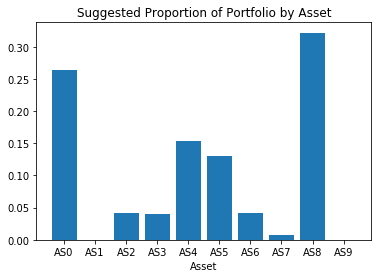

In [15]:
plt.bar(ASSETS, prop)
plt.xlabel("Asset")
plt.title("Suggested Proportion of Portfolio by Asset")
plt.show()

*** 
## Conclusion
In today’s notebook, we used the sasoptpy package to suggest our portfolio proportions to maximize expected returns while accounting for risk. 

If you want to learn more about sasoptpy, please check out [the sasoptpy GitHub page]( https://github.com/sassoftware/sasoptpy) or [the sasoptypy documentation.]( https://sassoftware.github.io/sasoptpy/overview/overview.html) 

Want to dive deeper into optimization for data science? Then please check out [the Optimization Concepts for Data Science and Artificial Intelligence!](https://support.sas.com/edu/schedules.html?id=18581&ctry=US)